<a href="https://colab.research.google.com/github/ekalmes/Portfolio/blob/main/LogisticRegressionAdultIncome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise - Logistic Regression - Adult Income
by Zeke Kalmes and Brad Sheese

* Create a notebook that uses logistic regression to examine predictors of adult income (Over 50k, Under 50k)
* Begin by building a notebook that retrievs the data from the data source below
* The data has been split into two files (test and train), get the data from both files, clean up the data then combine them back into a single file. We will create out own test and train data sets. 
* Use skLearn with model cross-validation
* Do not specify a solver
* Use the pandas `pd.get_dummies()` function to one hot encode features
* Do not one hot encode binary features into two separate features
* Normalize all continous predictors
* Create a reduced model that has best results you can get with seven or fewer features
* State your conlusion at the end of your notebook (bullet points are fine)







In [ ]:
#@title Getting started? Execute this cell first.
#@markdown Click on the arrow to the left to execute this cell.

# set exercise name here
exercise_name = '12.0.132 Logistic Regression Adult Income'

import os
import sys
import math

tool_path = '/content/cs125_tools/'

if not os.path.exists(tool_path):
  ! git clone --quiet https://github.com/bsheese/cs125_tools.git

if tool_path not in sys.path:
  sys.path.append(tool_path)

import exercise_report_response

exercise_report_response.exercise_time_difficulty_report(exercise_name)

,Time
30 min or less,0%
31-60 min,0%
61-90 min,0%
91-120 min,0%
More than 2 hours,100%


,Difficulty
Very Easy,0%
Somewhat Easy,0%
Neutral,20%
Somewhat Difficult,0%
Very Difficult,80%


## Data Source

The data is [hosted at UCI](https://archive.ics.uci.edu/ml/datasets/adult).
*   [Folder: Data files](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/)




---




## Imports and Data


In [ ]:
%%capture
!pip install pingouin

In [ ]:
import pingouin as pg
import pandas as pd
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
import urllib.request as request
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import of Helper Functions from Dr. Sheese

In [ ]:
def print_parameter_coefficients(parameter_estimates):
  '''
  takes a fitted model and set of features (X)
  prints model parameter coefficients
  '''
  print('The parameter coefficients are:\n')

  for a in parameter_estimates:
    coefficient = round(a[1], 4)
    print(f'\t{a[0]}: {coefficient}')
  print()

def print_classification_report(predictions, y_test):
  '''
  prints classifications report of predictions
  takes fitted model, X_test and y_test
  '''
  # classification report
  print('\nClassification Report:\n')
  print(classification_report(y_test, predictions))
  print()

def print_confusion_matrix(y_test, predictions, condition1, condition2):
  # confusion matrix
  c_matrix = confusion_matrix(y_test, predictions)
  print('Confusion Matrix:\n')
  print('\tOur logistic regression model predicted the following when applied to the test data:\n')
  print(f'\tIt correctly predicted {c_matrix[0][0]} of {c_matrix[0][0] + c_matrix[0][1]} {condition1}, \n \
          but incorrectly predicted {c_matrix[0][1]} {condition1} that did not occur.\n')
  print(f'\tIt correctly predicted {c_matrix[1][1]} of {c_matrix[1][0] + c_matrix[1][1]} {condition2}, \n \
          but incorrectly predicted {c_matrix[1][0]} {condition2} that did not occur.\n')
  

  
def print_model_reports(logmodel, predictions, y_test, condition1, condition2,
                        parameter_report=False,
                        odds_ratio_report=True):
  
  #print accuracy
  accuracy = accuracy_score(y_test, predictions)
  print('Prediction accuracy: ', accuracy)
  
  # report y intercept 
  print(f'The y-intercept of our model is {logmodel.intercept_[0].round(4)}')
  print()

  # print parameters, classification report, confusion matrix
  if parameter_report == True:
    print_parameter_coefficients(parameter_estimates)
  print_classification_report(predictions, y_test)
  print_confusion_matrix(y_test, predictions, condition1, condition2)

  #print odds ratios
  if odds_ratio_report == True:
    print('The odds ratios are:')
    for a in parameter_estimates:
      oddsratio = np.exp(a[1]).round(2)
      print(f'{a[0]}: {oddsratio}')

# Taking a look at the data

In [ ]:
df1 = pd.read_csv('https://raw.githubusercontent.com/Jmahaffey1/CS377Project6/main/adult.data', header=None) 
df2 = pd.read_csv('https://raw.githubusercontent.com/Jmahaffey1/CS377Project6/main/adult.test', header=None) # need header so we can save the first entry and rename later
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Becuase it took one of the entires to be the column names, it will have to be renamed

In [ ]:
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


None of the columns are missing data so we won't have to initally drop anything. 

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


In [ ]:
df.nunique()

age                  74
workclass             9
fnlwgt            28523
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        123
capital-loss         99
hours-per-week       96
native-country       42
income                4
dtype: int64

In [ ]:
df['age'].mean()

38.64358543876172

In [ ]:
df['education-num'].mean()

10.078088530363212

Most of the columns do not contain few unqiue values. Will have to replace sex with 1s and 0s

In [ ]:
col_list = df.columns.unique()
col_list

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [ ]:
df = df.drop(columns='fnlwgt') # at the recomendation of Dr. Sheese, lets drop duplicates and the fnlwgt column
df = df.drop_duplicates()

In [ ]:
df['income'] = df['income'].str.rstrip('.') # https://stackoverflow.com/questions/37001787/remove-ends-of-string-entries-in-pandas-dataframe-column

using .str.rstrip, remove the period from the second df

In [ ]:
sex_num = {' Male': 0, ' Female': 1}  # doing simple binary encoding for categorical vairables with only two unique values
income_num = {' <=50K': 0, ' >50K': 1}

In [ ]:
df.sex = [sex_num[i] for i in df.sex]  # changing male to 0 and female to 1 
df.income = [income_num[i] for i in df.income] # changing <=50k to 0 and >50k to 1

In [ ]:
df.head(10)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,0,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,0,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,1,0,0,40,Cuba,0
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,1,0,0,40,United-States,0
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,1,0,0,16,Jamaica,0
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,45,United-States,1
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,1,14084,0,50,United-States,1
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,0,5178,0,40,United-States,1


Now let's clean up some of the categoricals so we have less to work with. The first one I'll start with will be workclass.

In [ ]:
df['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [ ]:
def job_types(value):
  if value == ' Never-worked' or value == ' Without-pay':
    value = 'Unemployed'
    return value
  elif value == ' State-gov' or value == ' Local-gov' or value == ' Federal-gov':
    value = 'Gov-employed'
    return value
  elif value == ' Self-emp-not-inc' or value == ' Self-emp-inc':
    value = 'Self-employed'
    return value
  else:
    return value
df['workclass-category'] = df['workclass'].map(job_types)  # recreating the workclass column with less categoricals
df['workclass-category']

0         Gov-employed
1        Self-employed
2              Private
3              Private
4              Private
             ...      
48837          Private
48838                ?
48839          Private
48840          Private
48841    Self-employed
Name: workclass-category, Length: 44355, dtype: object

In [ ]:
def USA_born(value):
  if value == ' United-States':
    value = 1
    return value
  else:
    value = 'Non-US'
    return 0


df['native-country'] = df['native-country'].map(USA_born)  # recreating the workclass column with less categoricals
df['native-country']

0        1
1        1
2        1
3        1
4        0
        ..
48837    1
48838    1
48839    1
48840    1
48841    1
Name: native-country, Length: 44355, dtype: int64

There are about 39,000 entries from the US and around 4500 entries not from the US. 

In [ ]:
df['race'].unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

In [ ]:
pd.crosstab(df['income'], df['race'], margins=True, normalize=True)

race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,All
income,,,,,,
0,0.009356,0.025003,0.090677,0.008026,0.621982,0.755045
1,0.001240,0.009221,0.012693,0.001127,0.220674,0.244955
All,0.010596,0.034224,0.103371,0.009153,0.842656,1.000000


In [ ]:
pd.crosstab(df['income'], df['sex'], margins=True, normalize=True)

sex,0,1,All
income,,,
0,0.456296,0.298749,0.755045
1,0.205794,0.039161,0.244955
All,0.662090,0.337910,1.000000


We can see that the majority of the entries are white males. Whites make up 84% of the entries and males make up 66% of the entries. 75% of the entires do not earn above 50k. 

In [ ]:
df['marital-status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [ ]:
def marriage_status(value):
  if value == ' Separated' or value == ' Widowed' or value == ' Divorced':
    value = 'Not-married'
    return value
  elif value == ' Never-married':
    value = 'Never-married'
    return value
  else:
    value = 'Married'
    return value

df['marital-status'] = df['marital-status'].map(marriage_status)
df[df['marital-status'] == 'Not-married']

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass-category
2,38,Private,HS-grad,9,Not-married,Handlers-cleaners,Not-in-family,White,0,0,0,40,1,0,Private
19,43,Self-emp-not-inc,Masters,14,Not-married,Exec-managerial,Unmarried,White,1,0,0,45,1,1,Self-employed
21,54,Private,HS-grad,9,Not-married,Other-service,Unmarried,Black,1,0,0,20,1,0,Private
24,59,Private,HS-grad,9,Not-married,Tech-support,Unmarried,White,1,0,0,40,1,0,Private
28,39,Private,HS-grad,9,Not-married,Exec-managerial,Not-in-family,White,0,0,0,80,1,0,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48829,58,Private,Assoc-acdm,12,Not-married,Prof-specialty,Not-in-family,White,0,0,0,36,1,0,Private
48835,48,Local-gov,Masters,14,Not-married,Other-service,Not-in-family,White,0,0,0,40,1,0,Gov-employed
48837,39,Private,Bachelors,13,Not-married,Prof-specialty,Not-in-family,White,1,0,0,36,1,0,Private
48838,64,?,HS-grad,9,Not-married,?,Other-relative,Black,0,0,0,40,1,0,?


In [ ]:
pd.crosstab(df['income'], df['marital-status'], margins=True, normalize=True)

marital-status,Married,Never-married,Not-married,All
income,,,,
0,0.260782,0.302649,0.191613,0.755045
1,0.208432,0.016390,0.020133,0.244955
All,0.469214,0.319040,0.211746,1.000000


Married people make up a majority of the dataset with 47%. I could split into married and not married but I think the categorization is okay for now. 

In [ ]:
df['occupation'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [ ]:
df['education'].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [ ]:
def cat_education(value):
  if value in (' 11th', ' 9th', ' 7th-8th', ' 5th-6th', ' 10th', ' 1st-4th', ' 12th', ' Preschool', ' Prof-school'):
    value = 'No-highschool-grad'
    return value
  elif value in (' HS-grad', ' Some-college', ' Assoc-acdm', ' Assoc-voc'):
    value = 'Some-college'
    return value
  else:
    value = 'Higher-education'
    return value

df['education'] = df['education'].map(cat_education)
df


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass-category
0,39,State-gov,Higher-education,13,Never-married,Adm-clerical,Not-in-family,White,0,2174,0,40,1,0,Gov-employed
1,50,Self-emp-not-inc,Higher-education,13,Married,Exec-managerial,Husband,White,0,0,0,13,1,0,Self-employed
2,38,Private,Some-college,9,Not-married,Handlers-cleaners,Not-in-family,White,0,0,0,40,1,0,Private
3,53,Private,No-highschool-grad,7,Married,Handlers-cleaners,Husband,Black,0,0,0,40,1,0,Private
4,28,Private,Higher-education,13,Married,Prof-specialty,Wife,Black,1,0,0,40,0,0,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,Higher-education,13,Not-married,Prof-specialty,Not-in-family,White,1,0,0,36,1,0,Private
48838,64,?,Some-college,9,Not-married,?,Other-relative,Black,0,0,0,40,1,0,?
48839,38,Private,Higher-education,13,Married,Prof-specialty,Husband,White,0,0,0,50,1,0,Private
48840,44,Private,Higher-education,13,Not-married,Adm-clerical,Own-child,Asian-Pac-Islander,0,5455,0,40,1,0,Private


Here I have condensed into higher education, some college including highschool grads, and no highschool grad as anyone still in highschool or grade schoolers.

In [ ]:
pd.crosstab(df['income'], df['education'], margins=True, normalize=True)

education,Higher-education,No-highschool-grad,Some-college,All
income,,,,
0,0.127584,0.134709,0.492752,0.755045
1,0.108421,0.021801,0.114733,0.244955
All,0.236005,0.156510,0.607485,1.000000


In [ ]:
df['relationship'].unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

In [ ]:
def rel_change(value):
  if value in (' Not-in-family', ' Unmarried'):
    value = 0
    return value
  else:
    value = 1
    return value

df['relationship'] = df['relationship'].map(rel_change)
df['relationship'].unique()

array([0, 1])

Stating whether they are alone based on not being in a family or being unmarried. 0 will for alone people and 1 will be for not alone people.

In [ ]:
def cat_race(value):
  if value == ' White':
    return 0
  else:
    value = 'Minority'
    return 1

df['race'] = df['race'].map(cat_race)
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass-category
0,39,State-gov,Higher-education,13,Never-married,Adm-clerical,0,0,0,2174,0,40,1,0,Gov-employed
1,50,Self-emp-not-inc,Higher-education,13,Married,Exec-managerial,1,0,0,0,0,13,1,0,Self-employed
2,38,Private,Some-college,9,Not-married,Handlers-cleaners,0,0,0,0,0,40,1,0,Private
3,53,Private,No-highschool-grad,7,Married,Handlers-cleaners,1,1,0,0,0,40,1,0,Private
4,28,Private,Higher-education,13,Married,Prof-specialty,1,1,1,0,0,40,0,0,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,Higher-education,13,Not-married,Prof-specialty,0,0,1,0,0,36,1,0,Private
48838,64,?,Some-college,9,Not-married,?,1,1,0,0,0,40,1,0,?
48839,38,Private,Higher-education,13,Married,Prof-specialty,1,0,0,0,0,50,1,0,Private
48840,44,Private,Higher-education,13,Not-married,Adm-clerical,1,1,0,5455,0,40,1,0,Private


0 will be for white and 1 will be for minority.

In [ ]:
pd.crosstab(df['income'], df['race'], margins=True, normalize=True)

race,0,1,All
income,,,
0,0.621982,0.133063,0.755045
1,0.220674,0.024281,0.244955
All,0.842656,0.157344,1.000000


Condensed into white and minority. Minorities only make up roughly 15% of the dataset. 

In [ ]:
df['education'].describe()

count            44355
unique               3
top       Some-college
freq             26945
Name: education, dtype: object

In [ ]:
df['sex'].value_counts()

0    29367
1    14988
Name: sex, dtype: int64

In [ ]:
df.columns

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'income',
       'workclass-category'],
      dtype='object')

In [ ]:
my_colors = ['purple','g','b']

Text(0.5, 1.0, 'Marriage Distribution')

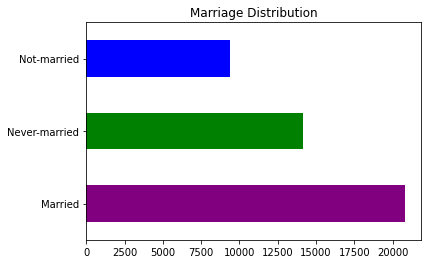

In [ ]:
df['marital-status'].value_counts().plot(kind='barh', color=my_colors)
plt.title('Marriage Distribution')

# Data Normalization of continuous variables

In [ ]:
norm_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']  # https://stackoverflow.com/questions/28576540/how-can-i-normalize-the-data-in-a-range-of-columns-in-my-pandas-dataframe
df[norm_cols] = df[norm_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min())) # use of lambda function to normalize non-categorical data

## Data Cleaning Recap

I have made changes to all categorical predictors so it would be easier to do one hot encoding with the exception of occupation. Some info on the dataset:


*   The dataset consists of mostly white males, married individuals, people working in a private sector, and people who have done some college.
*   Minorities only make up 15% of the dataset and women make up about 33%.



## Start of Logistic Regression
We can now start with working towards getting the model. The first step will be to hot encode everything.

In [ ]:
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass-category
0,0.301370,State-gov,Higher-education,0.800000,Never-married,Adm-clerical,0,0,0,0.021740,0.0,0.397959,1,0,Gov-employed
1,0.452055,Self-emp-not-inc,Higher-education,0.800000,Married,Exec-managerial,1,0,0,0.000000,0.0,0.122449,1,0,Self-employed
2,0.287671,Private,Some-college,0.533333,Not-married,Handlers-cleaners,0,0,0,0.000000,0.0,0.397959,1,0,Private
3,0.493151,Private,No-highschool-grad,0.400000,Married,Handlers-cleaners,1,1,0,0.000000,0.0,0.397959,1,0,Private
4,0.150685,Private,Higher-education,0.800000,Married,Prof-specialty,1,1,1,0.000000,0.0,0.397959,0,0,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.301370,Private,Higher-education,0.800000,Not-married,Prof-specialty,0,0,1,0.000000,0.0,0.357143,1,0,Private
48838,0.643836,?,Some-college,0.533333,Not-married,?,1,1,0,0.000000,0.0,0.397959,1,0,?
48839,0.287671,Private,Higher-education,0.800000,Married,Prof-specialty,1,0,0,0.000000,0.0,0.500000,1,0,Private
48840,0.369863,Private,Higher-education,0.800000,Not-married,Adm-clerical,1,1,0,0.054551,0.0,0.397959,1,0,Private


In [ ]:
encoded_workclass = pd.get_dummies(df['workclass-category'], prefix='worktype')
encoded_workclass

,worktype_ ?,worktype_ Private,worktype_Gov-employed,worktype_Self-employed,worktype_Unemployed
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
48837,0,1,0,0,0
48838,1,0,0,0,0
48839,0,1,0,0,0
48840,0,1,0,0,0


Now that we have encoded work category we can now go on to do occupation, marriage status, and education.

In [ ]:
encoded_occupation = pd.get_dummies(df['occupation'], prefix='job')
encoded_education = pd.get_dummies(df['education'], prefix='schooling')
encoded_marriage = pd.get_dummies(df['marital-status'])

cols = ['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
new_df = df[cols]  # creation of new df without encoded variables

new_df = new_df.join(encoded_workclass)  # addition of encoded variables
new_df = new_df.join(encoded_occupation)
new_df = new_df.join(encoded_education)
new_df = new_df.join(encoded_marriage)
new_df

,age,education-num,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,worktype_ ?,worktype_ Private,worktype_Gov-employed,worktype_Self-employed,worktype_Unemployed,job_ ?,job_ Adm-clerical,job_ Armed-Forces,job_ Craft-repair,job_ Exec-managerial,job_ Farming-fishing,job_ Handlers-cleaners,job_ Machine-op-inspct,job_ Other-service,job_ Priv-house-serv,job_ Prof-specialty,job_ Protective-serv,job_ Sales,job_ Tech-support,job_ Transport-moving,schooling_Higher-education,schooling_No-highschool-grad,schooling_Some-college,Married,Never-married,Not-married
0,0.301370,0.800000,0,0,0,0.021740,0.0,0.397959,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.452055,0.800000,1,0,0,0.000000,0.0,0.122449,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0.287671,0.533333,0,0,0,0.000000,0.0,0.397959,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,0.493151,0.400000,1,1,0,0.000000,0.0,0.397959,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0.150685,0.800000,1,1,1,0.000000,0.0,0.397959,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.301370,0.800000,0,0,1,0.000000,0.0,0.357143,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
48838,0.643836,0.533333,1,1,0,0.000000,0.0,0.397959,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
48839,0.287671,0.800000,1,0,0,0.000000,0.0,0.500000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
48840,0.369863,0.800000,1,1,0,0.054551,0.0,0.397959,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


All categoricals have been encoded and Logistic regression can start.

In [ ]:
new_df.columns = ['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country',
       'worktype_ ?', 'worktype_ Private', 'worktype_Gov-employed',
       'worktype_Self-employed', 'worktype_Unemployed', 'job_ ?',
       'job_ Adm-clerical', 'job_ Armed-Forces', 'job_ Craft-repair',
       'job_ Exec-managerial', 'job_ Farming-fishing',
       'job_ Handlers-cleaners', 'job_ Machine-op-inspct',
       'job_ Other-service', 'job_ Priv-house-serv', 'job_ Prof-specialty',
       'job_ Protective-serv', 'job_ Sales', 'job_ Tech-support',
       'job_ Transport-moving', 'schooling_Higher-education',
       'schooling_No-highschool-grad', 'schooling_Some-college', 'Married',
       'Never-married', 'Not-married', 'income']  # moving income column to the end


In [ ]:
final_cols = new_df.columns[:-1].to_list()
final_cols

['age',
 'education-num',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'worktype_ ?',
 'worktype_ Private',
 'worktype_Gov-employed',
 'worktype_Self-employed',
 'worktype_Unemployed',
 'job_ ?',
 'job_ Adm-clerical',
 'job_ Armed-Forces',
 'job_ Craft-repair',
 'job_ Exec-managerial',
 'job_ Farming-fishing',
 'job_ Handlers-cleaners',
 'job_ Machine-op-inspct',
 'job_ Other-service',
 'job_ Priv-house-serv',
 'job_ Prof-specialty',
 'job_ Protective-serv',
 'job_ Sales',
 'job_ Tech-support',
 'job_ Transport-moving',
 'schooling_Higher-education',
 'schooling_No-highschool-grad',
 'schooling_Some-college',
 'Married',
 'Never-married',
 'Not-married']

In [ ]:
pg.logistic_regression(new_df[final_cols], df['income'])

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,-9.474575,532.789395,-1.778296e-02,0.985812,-1053.722601,1034.773451
1,age,-1.149148,480.927348,-2.389441e-03,0.998094,-943.749429,941.451134
2,education-num,-2.180825,640.025864,-3.407401e-03,0.997281,-1256.608466,1252.246817
3,relationship,-0.586053,291.175829,-2.012711e-03,0.998394,-571.280191,570.108085
4,race,-0.520853,234.368751,-2.222364e-03,0.998227,-459.875163,458.833458
5,sex,-0.783450,203.453521,-3.850757e-03,0.996928,-399.545024,397.978123
6,capital-gain,1.278642,1202.972067,1.062902e-03,0.999152,-2356.503284,2359.060568
7,capital-loss,0.653371,730.869221,8.939650e-04,0.999287,-1431.823980,1433.130723
8,hours-per-week,-1.426605,622.674142,-2.291094e-03,0.998172,-1221.845498,1218.992288
9,native-country,-0.857208,222.895364,-3.845787e-03,0.996932,-437.724093,436.009677


Let's remove some of the predictors that have weak coefficients.

In [ ]:
cols_to_remove = ('relationship', 'worktype_ ?', 'worktype_ Private', 'worktype_Gov-employed',
       'worktype_Self-employed', 'worktype_Unemployed', 'job_ ?',
       'job_ Adm-clerical', 'job_ Armed-Forces', 'job_ Craft-repair',
       'job_ Exec-managerial', 'job_ Farming-fishing',
       'job_ Handlers-cleaners', 'job_ Machine-op-inspct',
       'job_ Other-service', 'job_ Priv-house-serv', 'job_ Prof-specialty',
       'job_ Protective-serv', 'job_ Sales', 'job_ Tech-support',
       'job_ Transport-moving', 'capital-gain', 'capital-loss')

for i in cols_to_remove:
  final_cols.remove(i)

In [ ]:
pg.logistic_regression(new_df[final_cols], df['income'])

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,-5.837924,0.098403,-59.326752,0.000000e+00,-6.030791,-5.645058
1,age,1.792582,0.084976,21.095160,8.810755e-99,1.626032,1.959132
2,education-num,5.458467,0.140864,38.749937,0.000000e+00,5.182379,5.734555
3,race,-0.243972,0.043890,-5.558764,2.716915e-08,-0.329995,-0.157950
4,sex,-0.219387,0.036764,-5.967440,2.410046e-09,-0.291443,-0.147331
5,hours-per-week,2.991702,0.112178,26.669324,1.068391e-156,2.771838,3.211566
6,native-country,0.296814,0.048270,6.149000,7.797282e-10,0.202206,0.391422
7,schooling_Higher-education,-0.177402,0.061680,-2.876174,4.025275e-03,-0.298293,-0.056512
8,schooling_No-highschool-grad,-1.967305,0.058247,-33.775472,4.520510e-250,-2.081466,-1.853144
9,schooling_Some-college,-1.876033,0.043679,-42.950064,0.000000e+00,-1.961643,-1.790423


From here we can see that the years of education, the hours per week, the type of schooling you have, and whether you are married can determine your salary. Let's remove some more.

In [ ]:
cols_to_remove2 = ('Not-married', 'race', 'sex', 'native-country', 'schooling_Higher-education', 'schooling_Some-college')
for i in cols_to_remove2:
  final_cols.remove(i)

In [ ]:
pg.logistic_regression(new_df[final_cols], df['income'])

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,-8.026811,0.108876,-73.724159,0.000000e+00,-8.240205,-7.813417
1,age,2.042665,0.081131,25.177370,7.089618e-140,1.883651,2.201679
2,education-num,5.520160,0.139450,39.585204,0.000000e+00,5.246843,5.793477
3,hours-per-week,3.176400,0.109841,28.918256,7.038733e-184,2.961117,3.391684
4,schooling_No-highschool-grad,-0.095282,0.069893,-1.363261,1.728004e-01,-0.232269,0.041705
5,Married,-0.088240,0.051979,-1.697608,8.958182e-02,-0.190118,0.013637
6,Never-married,2.274957,0.032181,70.692891,0.000000e+00,2.211884,2.338031


With 6 attriubutes, the accuracy is around .86

In [ ]:
pg.logistic_regression(new_df[final_cols], df['income'])

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,-8.026811,0.108876,-73.724159,0.000000e+00,-8.240205,-7.813417
1,age,2.042665,0.081131,25.177370,7.089618e-140,1.883651,2.201679
2,education-num,5.520160,0.139450,39.585204,0.000000e+00,5.246843,5.793477
3,hours-per-week,3.176400,0.109841,28.918256,7.038733e-184,2.961117,3.391684
4,schooling_No-highschool-grad,-0.095282,0.069893,-1.363261,1.728004e-01,-0.232269,0.041705
5,Married,-0.088240,0.051979,-1.697608,8.958182e-02,-0.190118,0.013637
6,Never-married,2.274957,0.032181,70.692891,0.000000e+00,2.211884,2.338031


Use Logistic Regression example from Dr. Sheese.

In [ ]:
X = new_df[final_cols]  # get every item in list except for last which is income
y = new_df['income']

# using the train_test_split method to create testing and training datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# create and fit the model
logmodel = LogisticRegression(max_iter=4000, class_weight = 'balanced').fit(X_train, y_train)

# create parameter estimates
loglist = logmodel.coef_.tolist()[0]
print(loglist)
parameter_estimates = list(zip(X.columns, loglist))

#create predictions
predictions = logmodel.predict(X_test)

# examine results
print_model_reports(logmodel, predictions, y_test, 'below or eqaul to 50k', 'above 50k',
                    parameter_report = False,
                    odds_ratio_report = False)

[10.044439401212607, -0.6805018889377564, 1.4051902156197171, -0.4113619358672329, 0.3010749649316462, -10.460543761038348]
Prediction accuracy:  0.8666245829200108
The y-intercept of our model is -1.9514


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      8776
           1       0.62      0.92      0.74      2313

    accuracy                           0.87     11089
   macro avg       0.80      0.89      0.83     11089
weighted avg       0.90      0.87      0.88     11089


Confusion Matrix:

	Our logistic regression model predicted the following when applied to the test data:

	It correctly predicted 7473 of 8776 below or eqaul to 50k, 
           but incorrectly predicted 1303 below or eqaul to 50k that did not occur.

	It correctly predicted 2137 of 2313 above 50k, 
           but incorrectly predicted 176 above 50k that did not occur.



In [ ]:
type(X_train)

pandas.core.frame.DataFrame

In [ ]:
type(y_train)

pandas.core.series.Series

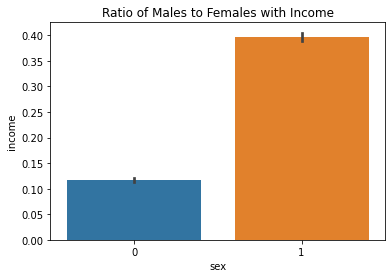

In [ ]:
sns.barplot(x=new_df['sex'],
            y=new_df['income'],
            data=new_df)

plt.title('Ratio of Males to Females with Income')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


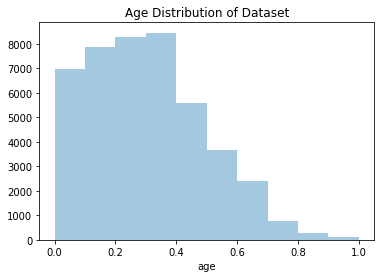

In [ ]:
fig = sns.distplot(df['age'], kde=False, bins=10)
plt.title('Age Distribution of Dataset')
plt.show()

9.701436140228374


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


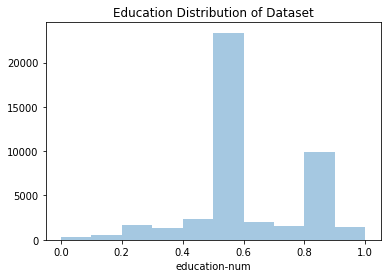

In [ ]:
fig = sns.distplot(df['education-num'], kde=False, bins=10)
plt.title('Education Distribution of Dataset')
print(0.6063397587642734 * 16)
plt.show()


In [ ]:
df['education-num'].mean()

0.6063397587642734

In [ ]:
df['hours-per-week'].mean()

0.40398523968268385

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


39.9945387285857


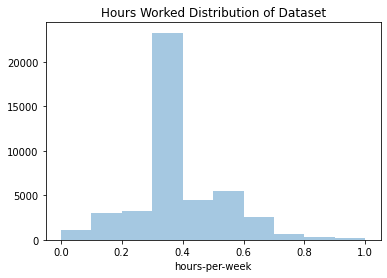

In [ ]:
fig = sns.distplot(df['hours-per-week'], kde=False, bins=10)
plt.title('Hours Worked Distribution of Dataset')
print(99 * 0.40398523968268385)
plt.show()

In [ ]:
#@title Completed the exercise? 
#@markdown Click on the arrow to the left to create the response form.

import sys
if 'exercise_report_response' not in sys.modules:
  print('Please execute the "Getting Started" cell at the beginning of this exercise, then rerun this cell.')
else:
  exercise_report_response.display_form(exercise_report_response.er_question_list)

If this form does not display correctly in Colab, select "Runttime" from the menu at the top, then select "Restart and run all"
Your first name:


Text(value='', placeholder='Enter your first name here')


Your last name:


Text(value='', placeholder='Enter your last name here')


How difficult was the exercise?


ToggleButtons(button_style='warning', index=2, options=('Very Easy', 'Somewhat Easy', 'Neutral', 'Somewhat Dif…


How long did it take you to complete the exercise?


ToggleButtons(button_style='warning', index=2, options=('30 min or less', '31-60 min', '61-90 min', '91-120 mi…


What tools (or concepts) used in this exercise do you feel confident with?


Textarea(value='', placeholder='Enter your response here')


What tools (or concepts) do you still need practice with?


Textarea(value='', placeholder='Enter your response here')


What suggestions do you have for improving the exercise?


Textarea(value='', placeholder='Enter your response here')


What corrections should be made (typos. etc)?


Textarea(value='', placeholder='Enter your response here')


Share your notebook.
Select 'Share' at the top of the screen. Then select 'Get Link'.
Change the Link so anyone can view it.
Click 'Copy Link', then 'Done'. Paste the link here.


Textarea(value='', placeholder='Enter your response here')

In [ ]:
#@title Ready to Submit?
#@markdown If you have completed the exercise and the exercise response:
#@markdown * check the box 'Ready' box below 
#@markdown * execute this cell

Ready = True #@param {type:"boolean"}

try:
  if Ready == True:
    exercise_report_response.submit_exercise_response(exercise_name, exercise_report_response.er_question_list)

  else:
    print('NOT SUBMITTED!!!')
    print('Check the ready box if you are ready to submit your response.')

except:
  print('NOT SUBMITTED!!!')
  print('Execute the cell above to create the form.')

Please enter your first and last name in the form above and then rerun this cell.
